In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

In [11]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [13]:
# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by((Measurement.date).desc()).first()

('2017-08-23')

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.id, Measurement.station, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date <= '2017-08-23').filter(Measurement.date >= '2016-08-23').\
    order_by((Measurement.date).desc()).all()
    

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

df = pd.DataFrame(precip)
df.set_index('date', inplace=False,)
df.dropna().head()


date     id      station  prcp  tobs
0  2017-08-23   2724  USC00519397  0.00  81.0
1  2017-08-23   7635  USC00514830  0.00  82.0
2  2017-08-23  12187  USC00519523  0.08  82.0
3  2017-08-23  19550  USC00516128  0.45  76.0
4  2017-08-22   2723  USC00519397  0.00  82.0

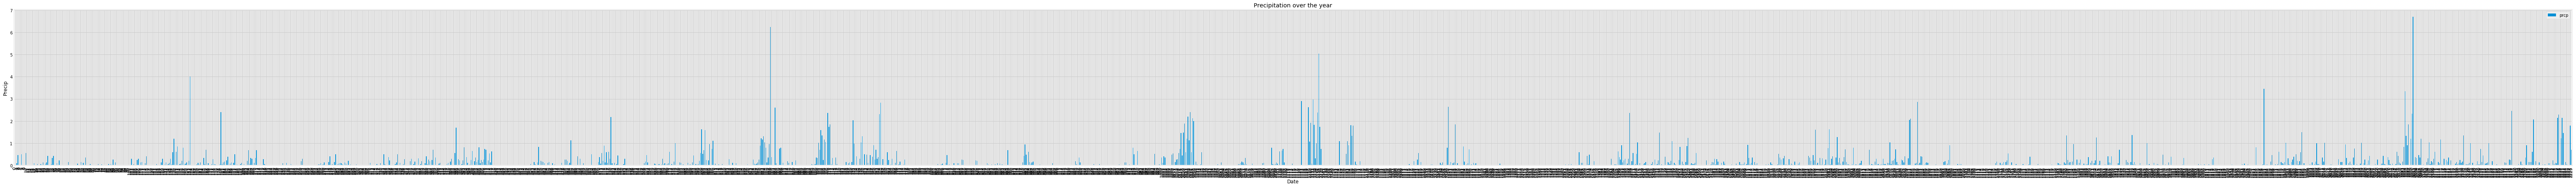

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
precip = df[['date','prcp']].plot(kind = 'bar', title="Precipitation over the year", figsize=(100,7))
precip.set_xlabel("Date")
precip.set_ylabel("Precip")
plt.show()

![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats_summary = df['prcp'].describe()
stats_summary

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

![describe](Images/describe.png)

In [18]:
# Design a query to show how many stations are available in this dataset?
df['station'].nunique()

7

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
df['station'].value_counts()

USC00519397    361
USC00519281    352
USC00516128    349
USC00513117    343
USC00519523    337
USC00514830    305
USC00517948    183
Name: station, dtype: int64

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_stat = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519397').all()
station_stat

[('USC00519397', 87.0, 56.0, 74.55323054331865)]

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df.groupby(['station']).count()

date   id  prcp  tobs
station                           
USC00513117   343  343   343   343
USC00514830   305  305   265   305
USC00516128   349  349   328   349
USC00517948   183  183    60   183
USC00519281   352  352   352   352
USC00519397   361  361   359   361
USC00519523   337  337   314   337

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A7DBEE2DD8>]],
      dtype=object)

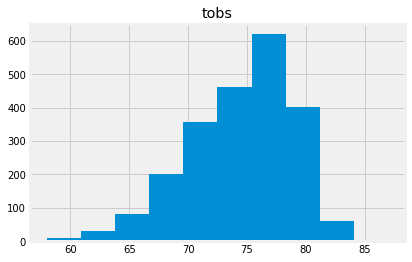

In [22]:
df.hist('tobs')

![precipitation](Images/station-histogram.png)

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [58]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_start = dt.date(2018, 7, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 7, 10) - dt.timedelta(days=365)

print(calc_temps(prev_year_start, prev_year_end))

[(69.0, 78.15254237288136, 87.0)]


In [59]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip = calc_temps(prev_year_start, prev_year_end)

for temp in trip:
    temp
min_temp = temp[0]
avg_temp = temp[1]
max_temp = temp[2]
peak = min_temp, max_temp

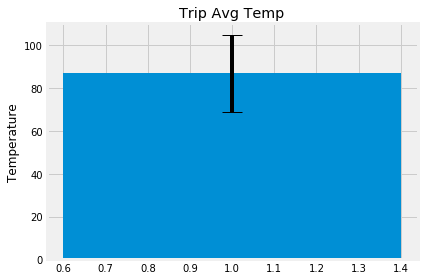

In [60]:
xpos = 1
plt.bar(xpos, max_temp, yerr=(min_temp-max_temp), capsize=10)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature")
plt.tight_layout()
plt.show()

In [69]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_rain = [Measurement.prcp, Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
station_vacation = session.query(*station_rain).filter(Measurement.station == Station.station).\
filter(Measurement.date <= prev_year_start).filter(Measurement.date >= prev_year_end).\
order_by((Measurement.date).desc()).all()

station_vacation

[]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


tmin       tavg  tmax
date                             
2018-01-01  62.0  69.153846  77.0
2018-01-02  60.0  69.396226  77.0
2018-01-03  62.0  68.909091  77.0
2018-01-04  58.0  70.000000  76.0
2018-01-05  56.0  67.964286  76.0

<IPython.core.display.Javascript object>


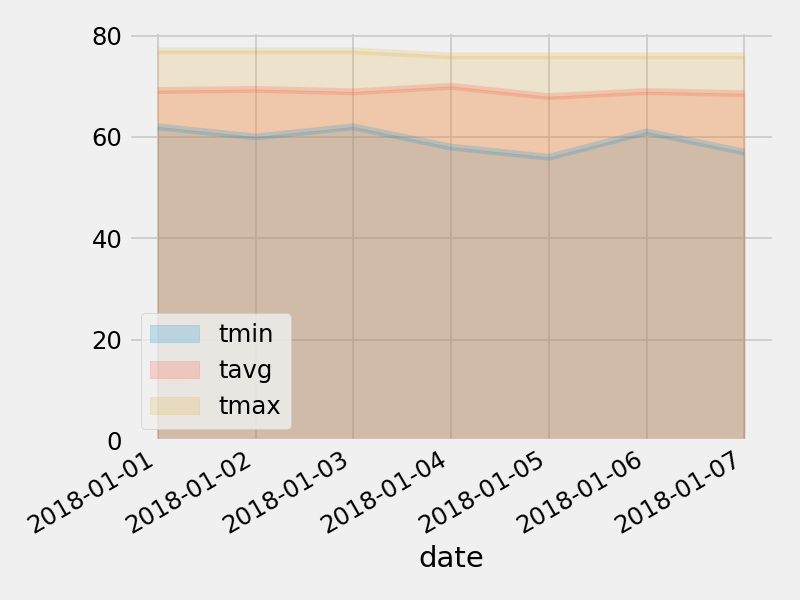

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
